In [ ]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import os
from tqdm import tqdm
import pickle
import warnings
warnings.filterwarnings('ignore')

DATA_PATH = "/kaggle/input/brytserc/"
EMOTIONS = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
PATIENCE = 7  
SAMPLE_RATE = 16000
DURATION = 3  
N_MELS = 128 
N_FFT = 2048
HOP_LENGTH = 512
FREEZE_BACKBONE = False  

Using device: cuda


In [ ]:
def extract_mel_spectrogram_resnet(audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_mels=n_mels,
        n_fft=n_fft,
        hop_length=hop_length
    )
    
    
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    return mel_spec_db

class ResNetEmotionDataset(Dataset):
    def __init__(self, audio_files, labels, sample_rate=SAMPLE_RATE, duration=DURATION):
        self.audio_files = audio_files
        self.labels = labels
        self.sample_rate = sample_rate
        self.duration = duration
        self.max_length = sample_rate * duration
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
     
        audio = self.audio_files[idx]
        label = self.labels[idx]
        
    
        if len(audio) > self.max_length:
            audio = audio[:self.max_length]
        else:
            audio = np.pad(audio, (0, self.max_length - len(audio)), mode='constant')
        
    
        mel_spec = extract_mel_spectrogram_resnet(audio)
        
  
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)
       
        mel_spec_3ch = np.stack([mel_spec, mel_spec, mel_spec], axis=0)
        
        return {
            'spectrogram': torch.FloatTensor(mel_spec_3ch),
            'label': torch.LongTensor([label])[0]
        }

def resnet_collate_fn(batch):
    spectrograms = torch.stack([item['spectrogram'] for item in batch])
    labels = torch.stack([item['label'] for item in batch])
    
    return {
        'spectrogram': spectrograms,
        'labels': labels
    }

In [ ]:
def load_emotion_data_resnet(data_path):
    all_features = []
    all_labels = []
    
    print("Loading data for ResNet50...")
    

    all_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]
    print(f"Found {len(all_files)} audio files")
    
    if len(all_files) == 0:
        raise ValueError(f"No .wav files found in {data_path}")
    

    emotion_counts = {emotion: 0 for emotion in EMOTIONS}
    
    for file in tqdm(all_files, desc="Loading audio files"):
        try:
            
            emotion_name = file.split('_')[0].lower()
            
         
            if emotion_name not in [e.lower() for e in EMOTIONS]:
                print(f"Warning: Unknown emotion '{emotion_name}' in file {file}")
                continue
            
    
            emotion_idx = [e.lower() for e in EMOTIONS].index(emotion_name)
            
       
            file_path = os.path.join(data_path, file)
            audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
            
            all_features.append(audio)
            all_labels.append(emotion_idx)
            emotion_counts[EMOTIONS[emotion_idx]] += 1
            
        except Exception as e:
            print(f"Error loading {file}: {e}")
            continue
    
    print("\nEmotion distribution:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion}: {count}")
    
    return all_features, np.array(all_labels)

features, labels = load_emotion_data_resnet(DATA_PATH)
print(f"\nTotal samples: {len(labels)}")

if len(labels) == 0:
    raise ValueError("No data loaded! Please check your data path and file format.")

print(f"Label distribution: {np.bincount(labels)}")

X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.4, random_state=42, stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain samples: {len(y_train)} ({len(y_train)/len(labels)*100:.1f}%)")
print(f"Validation samples: {len(y_val)} ({len(y_val)/len(labels)*100:.1f}%)")
print(f"Test samples: {len(y_test)} ({len(y_test)/len(labels)*100:.1f}%)")

train_dataset = ResNetEmotionDataset(X_train, y_train)
val_dataset = ResNetEmotionDataset(X_val, y_val)
test_dataset = ResNetEmotionDataset(X_test, y_test)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=resnet_collate_fn, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=resnet_collate_fn, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=resnet_collate_fn, num_workers=2
)

print("\nData loading complete!")
print(f"Spectrogram shape: {train_dataset[0]['spectrogram'].shape}")

Loading data for ResNet50...
Found 5215 audio files


Loading audio files: 100%|██████████| 5215/5215 [01:42<00:00, 50.66it/s]



Emotion distribution:
  angry: 745
  disgust: 745
  fear: 745
  happy: 745
  neutral: 745
  sad: 745
  surprise: 745

Total samples: 5215
Label distribution: [745 745 745 745 745 745 745]

Train samples: 3129 (60.0%)
Validation samples: 1043 (20.0%)
Test samples: 1043 (20.0%)

Data loading complete!
Spectrogram shape: torch.Size([3, 128, 94])


In [ ]:
class EmotionResNet50(nn.Module):
    def __init__(self, num_classes=7, dropout=0.5, freeze_backbone=False, pretrained=True):
        super(EmotionResNet50, self).__init__()
        
      
        if pretrained:
            print("Loading pre-trained ResNet50 weights from ImageNet...")
            self.resnet = models.resnet50(pretrained=True)
        else:
            print("Initializing ResNet50 from scratch...")
            self.resnet = models.resnet50(pretrained=False)
        
        
        if freeze_backbone:
            print("Freezing ResNet50 backbone layers...")
            for param in self.resnet.parameters():
                param.requires_grad = False
        
        
        num_features = self.resnet.fc.in_features
        
     
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        
        return self.resnet(x)

resnet_model = EmotionResNet50(
    num_classes=len(EMOTIONS),
    dropout=0.5,
    freeze_backbone=FREEZE_BACKBONE,
    pretrained=True
)

resnet_model = resnet_model.to(device)

print(f"\nResNet50 Model initialized")
print(f"Total parameters: {sum(p.numel() for p in resnet_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in resnet_model.parameters() if p.requires_grad):,}")


if FREEZE_BACKBONE:
    print("\n⚠️ Backbone is FROZEN - only training the classification head")
else:
    print("\n✓ Full model is TRAINABLE - fine-tuning all layers")

Loading pre-trained ResNet50 weights from ImageNet...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]



ResNet50 Model initialized
Total parameters: 24,691,783
Trainable parameters: 24,691,783

✓ Full model is TRAINABLE - fine-tuning all layers


In [ ]:
def train_epoch_resnet(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    progress_bar = tqdm(dataloader, desc="Training")
    
    for batch in progress_bar:
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        
  
        optimizer.zero_grad()
        

        logits = model(spectrogram)
        loss = criterion(logits, labels)
        

        loss.backward()
        
       
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.cpu().numpy())
    
        progress_bar.set_postfix({'loss': loss.item()})
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def validate_resnet(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validating"):
            spectrogram = batch['spectrogram'].to(device)
            labels = batch['labels'].to(device)
            
     
            logits = model(spectrogram)
            loss = criterion(logits, labels)
            
      
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy, predictions, true_labels

In [ ]:

criterion = nn.CrossEntropyLoss()


if FREEZE_BACKBONE:
    optimizer = optim.AdamW(resnet_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
else:
   
    optimizer = optim.AdamW([
        {'params': resnet_model.resnet.layer1.parameters(), 'lr': LEARNING_RATE * 0.1},
        {'params': resnet_model.resnet.layer2.parameters(), 'lr': LEARNING_RATE * 0.1},
        {'params': resnet_model.resnet.layer3.parameters(), 'lr': LEARNING_RATE * 0.5},
        {'params': resnet_model.resnet.layer4.parameters(), 'lr': LEARNING_RATE * 0.5},
        {'params': resnet_model.resnet.fc.parameters(), 'lr': LEARNING_RATE}
    ], weight_decay=1e-4)


scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=5, verbose=True, min_lr=1e-7
)

history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}


best_val_accuracy = 0.0
best_model_state = None
best_epoch = 0
patience_counter = 0

print("\n" + "="*50)
print("Starting ResNet50 Training")
print("="*50)

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch_resnet(resnet_model, train_loader, criterion, optimizer, device)
    

    val_loss, val_acc, _, _ = validate_resnet(resnet_model, val_loader, criterion, device)
 
    scheduler.step(val_acc)
    

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
 
    current_lr = optimizer.param_groups[-1]['lr'] 
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"Learning Rate: {current_lr:.7f}")
    

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        best_epoch = epoch + 1
        best_model_state = resnet_model.state_dict().copy()
        patience_counter = 0
        print(f"✓ New best model! Validation accuracy: {val_acc:.4f}")
        
  
        torch.save({
            'epoch': epoch,
            'model_state_dict': best_model_state,
            'optimizer_state_dict': optimizer.state_dict(),
            'val_accuracy': best_val_accuracy,
            'history': history
        }, 'best_resnet50_emotion_model.pth')
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
    
    if patience_counter >= PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print("\n" + "="*50)
print("ResNet50 Training Complete!")
print(f"Best validation accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}")
print("="*50)


resnet_model.load_state_dict(best_model_state)
print("\nBest ResNet50 model loaded for evaluation")


Starting ResNet50 Training

Epoch 1/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.21it/s]



Train Loss: 2.0266 | Train Acc: 0.2167
Val Loss: 1.6428 | Val Acc: 0.3720
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.3720

Epoch 2/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.07it/s]



Train Loss: 1.5724 | Train Acc: 0.4043
Val Loss: 1.3239 | Val Acc: 0.5244
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.5244

Epoch 3/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.77it/s]



Train Loss: 1.1611 | Train Acc: 0.5954
Val Loss: 1.1521 | Val Acc: 0.6040
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6040

Epoch 4/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.04it/s]



Train Loss: 0.7624 | Train Acc: 0.7498
Val Loss: 1.0274 | Val Acc: 0.6510
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6510

Epoch 5/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.31it/s]



Train Loss: 0.4426 | Train Acc: 0.8623
Val Loss: 1.0545 | Val Acc: 0.6568
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6568

Epoch 6/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.99it/s]



Train Loss: 0.2446 | Train Acc: 0.9345
Val Loss: 1.1571 | Val Acc: 0.6424
Learning Rate: 0.0001000
No improvement. Patience: 1/7

Epoch 7/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.17it/s]



Train Loss: 0.1585 | Train Acc: 0.9569
Val Loss: 1.1705 | Val Acc: 0.6596
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6596

Epoch 8/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.98it/s]



Train Loss: 0.1207 | Train Acc: 0.9652
Val Loss: 1.2414 | Val Acc: 0.6587
Learning Rate: 0.0001000
No improvement. Patience: 1/7

Epoch 9/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.20it/s]



Train Loss: 0.0967 | Train Acc: 0.9751
Val Loss: 1.3076 | Val Acc: 0.6692
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6692

Epoch 10/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.08it/s]



Train Loss: 0.0784 | Train Acc: 0.9824
Val Loss: 1.2273 | Val Acc: 0.6951
Learning Rate: 0.0001000
✓ New best model! Validation accuracy: 0.6951

Epoch 11/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.50it/s]



Train Loss: 0.0710 | Train Acc: 0.9786
Val Loss: 1.3439 | Val Acc: 0.6779
Learning Rate: 0.0001000
No improvement. Patience: 1/7

Epoch 12/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.21it/s]



Train Loss: 0.0557 | Train Acc: 0.9837
Val Loss: 1.3543 | Val Acc: 0.6846
Learning Rate: 0.0001000
No improvement. Patience: 2/7

Epoch 13/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.02it/s]



Train Loss: 0.0743 | Train Acc: 0.9779
Val Loss: 1.5460 | Val Acc: 0.6529
Learning Rate: 0.0001000
No improvement. Patience: 3/7

Epoch 14/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.36it/s]



Train Loss: 0.0617 | Train Acc: 0.9863
Val Loss: 1.4576 | Val Acc: 0.6826
Learning Rate: 0.0001000
No improvement. Patience: 4/7

Epoch 15/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:03<00:00,  8.30it/s]



Train Loss: 0.0525 | Train Acc: 0.9840
Val Loss: 1.5638 | Val Acc: 0.6884
Learning Rate: 0.0001000
No improvement. Patience: 5/7

Epoch 16/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  8.10it/s]



Train Loss: 0.0490 | Train Acc: 0.9843
Val Loss: 1.5811 | Val Acc: 0.6836
Learning Rate: 0.0000500
No improvement. Patience: 6/7

Epoch 17/50
--------------------------------------------------


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.92it/s]


Train Loss: 0.0377 | Train Acc: 0.9882
Val Loss: 1.5717 | Val Acc: 0.6922
Learning Rate: 0.0000500
No improvement. Patience: 7/7

Early stopping triggered after 17 epochs

ResNet50 Training Complete!
Best validation accuracy: 0.6951 at epoch 10

Best ResNet50 model loaded for evaluation



Evaluating ResNet50 on Test Set


Validating: 100%|██████████| 33/33 [00:04<00:00,  7.95it/s]



Test Loss: 1.4582
Test Accuracy: 0.7220

ResNet50 Classification Report
              precision    recall  f1-score   support

       angry     0.7791    0.8523    0.8141       149
     disgust     0.6597    0.6376    0.6485       149
        fear     0.6405    0.6577    0.6490       149
       happy     0.8613    0.7919    0.8252       149
     neutral     0.7329    0.7181    0.7254       149
         sad     0.7532    0.7785    0.7657       149
    surprise     0.6301    0.6174    0.6237       149

    accuracy                         0.7220      1043
   macro avg     0.7224    0.7220    0.7217      1043
weighted avg     0.7224    0.7220    0.7217      1043



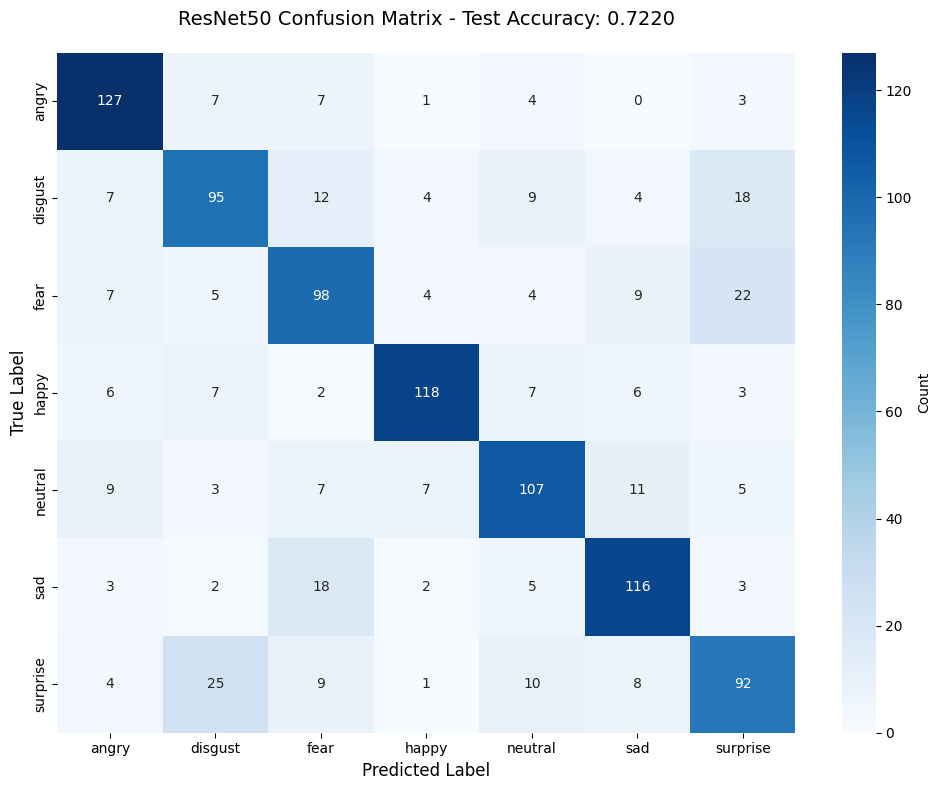


Confusion matrix saved as 'resnet50_confusion_matrix.png'


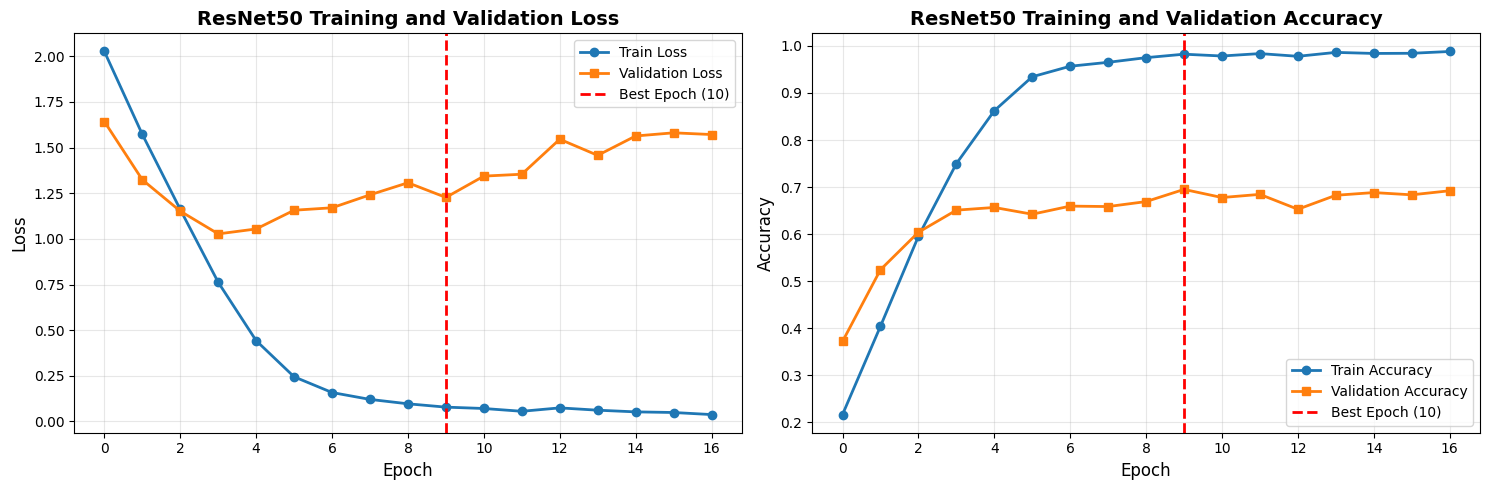

Training history saved as 'resnet50_training_history.png'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("\n" + "="*50)
print("Evaluating ResNet50 on Test Set")
print("="*50)

test_loss, test_acc, test_predictions, test_true_labels = validate_resnet(
    resnet_model, test_loader, criterion, device
)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


print("\n" + "="*50)
print("ResNet50 Classification Report")
print("="*50)
print(classification_report(
    test_true_labels, 
    test_predictions, 
    target_names=EMOTIONS,
    digits=4
))


cm = confusion_matrix(test_true_labels, test_predictions)


plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=EMOTIONS,
    yticklabels=EMOTIONS,
    cbar_kws={'label': 'Count'}
)
plt.title(f'ResNet50 Confusion Matrix - Test Accuracy: {test_acc:.4f}', fontsize=14, pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('resnet50_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nConfusion matrix saved as 'resnet50_confusion_matrix.png'")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))


ax1.plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
ax1.plot(history['val_loss'], label='Validation Loss', marker='s', linewidth=2)
ax1.axvline(x=best_epoch-1, color='r', linestyle='--', linewidth=2, label=f'Best Epoch ({best_epoch})')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ResNet50 Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(history['val_acc'], label='Validation Accuracy', marker='s', linewidth=2)
ax2.axvline(x=best_epoch-1, color='r', linestyle='--', linewidth=2, label=f'Best Epoch ({best_epoch})')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('ResNet50 Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet50_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history saved as 'resnet50_training_history.png'")

In [ ]:

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_true_labels, test_predictions
)


results_df = pd.DataFrame({
    'Emotion': EMOTIONS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

results_df = results_df.round(4)
print("\n" + "="*50)
print("ResNet50 Per-Class Metrics")
print("="*50)
print(results_df.to_string(index=False))


results_df.to_csv('resnet50_per_class_results.csv', index=False)
print("\nPer-class results saved to 'resnet50_per_class_results.csv'")

summary = {
    'model_type': 'ResNet50',
    'pretrained': True,
    'freeze_backbone': FREEZE_BACKBONE,
    'num_emotions': len(EMOTIONS),
    'emotions': EMOTIONS,
    'total_epochs': len(history['train_loss']),
    'best_epoch': best_epoch,
    'train_samples': len(y_train),
    'val_samples': len(y_val),
    'test_samples': len(y_test),
    'best_val_accuracy': best_val_accuracy,
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'hyperparameters': {
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'num_epochs': NUM_EPOCHS,
        'patience': PATIENCE,
        'sample_rate': SAMPLE_RATE,
        'duration': DURATION,
        'n_mels': N_MELS,
        'n_fft': N_FFT,
        'hop_length': HOP_LENGTH,
        'freeze_backbone': FREEZE_BACKBONE
    },
    'model_parameters': {
        'total': sum(p.numel() for p in resnet_model.parameters()),
        'trainable': sum(p.numel() for p in resnet_model.parameters() if p.requires_grad)
    }
}


with open('resnet50_training_summary.pkl', 'wb') as f:
    pickle.dump(summary, f)

print("\nTraining summary saved to 'resnet50_training_summary.pkl'")

print("\n" + "="*50)
print("RESNET50 FINAL SUMMARY")
print("="*50)
print(f"Model: ResNet50 (Pre-trained on ImageNet)")
print(f"Backbone Status: {'FROZEN' if FREEZE_BACKBONE else 'FINE-TUNED'}")
print(f"Total Parameters: {summary['model_parameters']['total']:,}")
print(f"Trainable Parameters: {summary['model_parameters']['trainable']:,}")
print(f"Total Epochs Trained: {len(history['train_loss'])}")
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print("\nDataset Split:")
print(f"  Training: {len(y_train)} samples ({len(y_train)/len(labels)*100:.1f}%)")
print(f"  Validation: {len(y_val)} samples ({len(y_val)/len(labels)*100:.1f}%)")
print(f"  Test: {len(y_test)} samples ({len(y_test)/len(labels)*100:.1f}%)")
print("\nInput Configuration:")
print(f"  Sample Rate: {SAMPLE_RATE} Hz")
print(f"  Duration: {DURATION} seconds")
print(f"  Mel Bands: {N_MELS}")
print(f"  FFT Size: {N_FFT}")
print(f"  Hop Length: {HOP_LENGTH}")
print(f"  Input Shape: (3, {N_MELS}, time_steps)")
print("\nFiles saved:")
print("  - best_resnet50_emotion_model.pth (best model checkpoint)")
print("  - resnet50_confusion_matrix.png")
print("  - resnet50_training_history.png")
print("  - resnet50_per_class_results.csv")
print("  - resnet50_training_summary.pkl")
print("="*50)


predictions_df = pd.DataFrame({
    'True_Label': [EMOTIONS[i] for i in test_true_labels],
    'Predicted_Label': [EMOTIONS[i] for i in test_predictions],
    'True_Label_Index': test_true_labels,
    'Predicted_Label_Index': test_predictions,
    'Correct': [t == p for t, p in zip(test_true_labels, test_predictions)]
})

predictions_df.to_csv('resnet50_test_predictions.csv', index=False)
print("\nTest predictions saved to 'resnet50_test_predictions.csv'")

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
print("\nConfusion Matrix (Percentages):")
print(pd.DataFrame(cm_percent, index=EMOTIONS, columns=EMOTIONS).round(2))


print(f"ResNet50 Test Accuracy: {test_acc:.4f}")

print("="*50)


ResNet50 Per-Class Metrics
 Emotion  Precision  Recall  F1-Score  Support
   angry     0.7791  0.8523    0.8141      149
 disgust     0.6597  0.6376    0.6485      149
    fear     0.6405  0.6577    0.6490      149
   happy     0.8613  0.7919    0.8252      149
 neutral     0.7329  0.7181    0.7254      149
     sad     0.7532  0.7785    0.7657      149
surprise     0.6301  0.6174    0.6237      149

Per-class results saved to 'resnet50_per_class_results.csv'

Training summary saved to 'resnet50_training_summary.pkl'

RESNET50 FINAL SUMMARY
Model: ResNet50 (Pre-trained on ImageNet)
Backbone Status: FINE-TUNED
Total Parameters: 24,691,783
Trainable Parameters: 24,691,783
Total Epochs Trained: 17
Best Epoch: 10
Best Validation Accuracy: 0.6951
Test Accuracy: 0.7220
Test Loss: 1.4582

Dataset Split:
  Training: 3129 samples (60.0%)
  Validation: 1043 samples (20.0%)
  Test: 1043 samples (20.0%)

Input Configuration:
  Sample Rate: 16000 Hz
  Duration: 3 seconds
  Mel Bands: 128
  FFT Siz